In [1]:
import io
import typing
from urllib.request import urlopen

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2023-01-13 16:17:04.779730: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.__version__

'2.11.0'

In [3]:
class LayerScale(layers.Layer):
    """LayerScale as introduced in CaiT: https://arxiv.org/abs/2103.17239. - Going deeper with Image Transformers

    Args:
        init_values (float): LayerScale의 diagonal matrix 초기값.
        projection_dim (int): LayerScale에서 사용되는 projection dimension.
    """

    def __init__(self, init_values: float, projection_dim: int, **kwargs):
        super().__init__(**kwargs)
        #tf.ones((projection_dim,)) -> [projection_dim,1] shape의 1로 이루어진 vector [1,1,...,1]
        self.gamma = tf.Variable(init_values * tf.ones((projection_dim,)))

    def call(self, x, training=False):
        return x * self.gamma

In [4]:
class ClassAttention(layers.Layer):
    """Class attention as proposed in CaiT: https://arxiv.org/abs/2103.17239. - Going deeper with Image Transformers

    Args:
        projection_dim (int): attention에서 사용되는 query, key, value의 projection dimension 
        num_heads      (int): attention heads의 갯수.
        dropout_rate (float): attention scores와 final projected outputs에서 사용될 dropout rate.
    """

    def __init__(
        self, projection_dim: int, num_heads: int, dropout_rate: float, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_heads = num_heads

        head_dim = projection_dim // num_heads
        self.scale = head_dim**-0.5

        self.q = layers.Dense(projection_dim)
        self.k = layers.Dense(projection_dim)
        self.v = layers.Dense(projection_dim)
        self.attn_drop = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(projection_dim)
        self.proj_drop = layers.Dropout(dropout_rate)

    def call(self, x, training=False):
        batch_size, num_patches, num_channels = (
            tf.shape(x)[0],
            tf.shape(x)[1],
            tf.shape(x)[2],
        )

        # Query projection. `cls_token` embeddings이 queries로 사용됩니다.
        q = tf.expand_dims(self.q(x[:, 0]), axis=1)
        q = tf.reshape(q, (batch_size, 1, self.num_heads, num_channels // self.num_heads))  
       
        # Shape: (batch_size, 1, num_heads, dimension_per_head)
        q = tf.transpose(q, perm=[0, 2, 1, 3])
        scale = tf.cast(self.scale, dtype=q.dtype)
        q = q * scale

        # Key projection. Patch embeddings과 cls embedding이 keys로 사용됩니다.
        k = self.k(x)
        k = tf.reshape(k, (batch_size, num_patches, self.num_heads, num_channels // self.num_heads))  
        
        # Shape: (batch_size, num_tokens, num_heads, dimension_per_head)
        k = tf.transpose(k, perm=[0, 2, 1, 3])

        # Value projection. Patch embeddings과 cls embedding이 values로 사용됩니다.
        v = self.v(x)
        v = tf.reshape(v, (batch_size, num_patches, self.num_heads, num_channels // self.num_heads))
        v = tf.transpose(v, perm=[0, 2, 1, 3])

        #cls_token embedding과 patch embeddings의 attention scores 계산하는 부분입니다.
        attn = tf.matmul(q, k, transpose_b=True)
        attn = tf.nn.softmax(attn, axis=-1)
        attn = self.attn_drop(attn, training)

        x_cls = tf.matmul(attn, v)
        x_cls = tf.transpose(x_cls, perm=[0, 2, 1, 3])
        x_cls = tf.reshape(x_cls, (batch_size, 1, num_channels))
        x_cls = self.proj(x_cls)
        x_cls = self.proj_drop(x_cls, training)

        return x_cls, attn

In [5]:
class TalkingHeadAttention(layers.Layer):
    """Talking-head attention as proposed in CaiT: https://arxiv.org/abs/2003.02436. - Talking-Heads Attention

    Args:
        projection_dim (int): attention에서 사용되는 query, key, value의 projection dimension 
        num_heads      (int): attention heads의 갯수.
        dropout_rate (float): attention scores와 final projected outputs에서 사용될 dropout rate.
    """

    def __init__(
        self, projection_dim: int, num_heads: int, dropout_rate: float, **kwargs
    ):
        super().__init__(**kwargs)

        self.num_heads = num_heads

        head_dim = projection_dim // self.num_heads

        self.scale = head_dim**-0.5

        self.qkv = layers.Dense(projection_dim * 3)
        self.attn_drop = layers.Dropout(dropout_rate)

        self.proj = layers.Dense(projection_dim)

        self.proj_l = layers.Dense(self.num_heads)
        self.proj_w = layers.Dense(self.num_heads)

        self.proj_drop = layers.Dropout(dropout_rate)

    def call(self, x, training=False):
        B, N, C = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2]

        # Project the inputs all at once.
        qkv = self.qkv(x)

        # query, key, and value projections의 형태로 분리될 수 있도록 projected output을 Reshape함.
        qkv = tf.reshape(qkv, (B, N, 3, self.num_heads, C // self.num_heads))

        # `num_heads`가 leading dimensions이 되어 sub-spaces들의 표현이 더 잘(?) 분리될수 있도록  Transpose함.

        qkv = tf.transpose(qkv, perm=[2, 0, 3, 1, 4])
        scale = tf.cast(self.scale, dtype=qkv.dtype)
        q, k, v = qkv[0] * scale, qkv[1], qkv[2]

        # raw attention scores 얻음.
        attn = tf.matmul(q, tf.transpose(k, perm=[0, 1, 3, 2]))

        # Softmax 이전에 사용되는 linear 1- query and key projections간의 유사도의 Linear projection.
        attn = self.proj_l(tf.transpose(attn, perm=[0, 2, 3, 1]))

        # Normalize the attention scores.
        attn = tf.transpose(attn, perm=[0, 3, 1, 2])
        attn = tf.nn.softmax(attn, axis=-1)

        # Softmax 이후에 사용되는 linear 2-  softmaxed scores의 Linear projection.
        attn = self.proj_w(tf.transpose(attn, perm=[0, 2, 3, 1]))
        attn = tf.transpose(attn, perm=[0, 3, 1, 2])
        attn = self.attn_drop(attn, training)

        # Vanilla attention mechanism에서 사용된것과 같은 Final set of projections.
        x = tf.matmul(attn, v)
        x = tf.transpose(x, perm=[0, 2, 1, 3])
        x = tf.reshape(x, (B, N, C))

        x = self.proj(x)
        x = self.proj_drop(x, training)

        return x, attn


In [6]:
class StochasticDepth(layers.Layer):
    """Stochastic Depth layer (https://arxiv.org/abs/1603.09382). - Deep Networks with Stochastic Depth

    Reference:
        https://github.com/rwightman/pytorch-image-models
    """

    def __init__(self, drop_prob: float, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x, training=False):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x


In [7]:
def mlp(x, dropout_rate: float, hidden_units: typing.List[int]):
    """FFN for a Transformer block."""
    for (idx, units) in enumerate(hidden_units):
        x = layers.Dense(
            units,
            activation=tf.nn.gelu if idx == 0 else None,
            bias_initializer=keras.initializers.RandomNormal(stddev=1e-6),
        )(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [8]:
def LayerScaleBlock(
    projection_dim : int,
    num_heads      : int,
    layer_norm_eps : float,
    init_values    : float,
    mlp_units      : typing.List[int],
    dropout_rate   : float,
    sd_prob        : float,
    name           : str,
):
    """ image patches의 embeddings에 적용되는 Pre-norm transfomer block임    
    Includes LayerScale and Stochastic Depth.

        Args:
            projection_dim   (int): Transformer blocks과 patch projection layer에 사용될 projection dimension.
            num_heads        (int): attention heads의 갯수.
            layer_norm_eps (float): Layer Normalization에 사용될 epsilon.
            init_values    (float): LayerScale에서 사용되는 diagonal matrix의 초기값.
            mlp_units  (List[int]): Transformer blocks에서 사용되는 feed-forward network의 dimensions.
            dropout_rate   (float): attention scores와 final projected outputs에서 사용될 dropout rate.    
            sd_prob        (float): stochastic depth rate.
            name             (str): block들에 붙여줄 이름(identifier).        

    Returns:
        A keras.Model instance.
    """
    encoded_patches = keras.Input((None, projection_dim))

    # Self-attention.
    x1 = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    attn_output, attn_scores = TalkingHeadAttention(projection_dim, num_heads, dropout_rate)(x1)
    attn_output = (
        LayerScale(init_values, projection_dim)(attn_output)
        if init_values
        else attn_output
    )
    attn_output = StochasticDepth(sd_prob)(attn_output) if sd_prob else attn_output
    x2 = layers.Add()([encoded_patches, attn_output])

    # FFN.
    x3 = layers.LayerNormalization(epsilon=layer_norm_eps)(x2)
    x4 = mlp(x3, hidden_units=mlp_units, dropout_rate=dropout_rate)
    x4 = LayerScale(init_values, projection_dim)(x4) if init_values else x4
    x4 = StochasticDepth(sd_prob)(x4) if sd_prob else x4
    outputs = layers.Add()([x2, x4])

    return keras.Model(encoded_patches, [outputs, attn_scores], name=name)

In [9]:
def LayerScaleBlockClassAttention(
    projection_dim : int,
    num_heads      : int,
    layer_norm_eps : float,
    init_values    : float,
    mlp_units      : typing.List[int],
    dropout_rate   : float,
    sd_prob        : float,
    name           : str,
):
    """ image patches과 cls token의 embeddings에 적용되는 Pre-norm transfomer block임.
    Includes LayerScale and Stochastic Depth.

    Args:   
            
        projection_dim   (int): Transformer blocks과 patch projection layer에 사용될 projection dimension.
        num_heads        (int): attention heads의 갯수.
        layer_norm_eps (float): Layer Normalization에 사용될 epsilon.
        init_values    (float): LayerScale에서 사용되는 diagonal matrix의 초기값.
        mlp_units  (List[int]): Transformer blocks에서 사용되는 feed-forward network의 dimensions.
        dropout_rate   (float): attention scores와 final projected outputs에서 사용될 dropout rate.    
        sd_prob        (float): stochastic depth rate.
        name             (str): block들에 붙여줄 이름(identifier).

    Returns:
        A keras.Model instance.
    """
    # x 가 SA에서 사용됐던 embedded patch와 같은 내용이고
    # 여기서 새롭게 cls가 정의되는모습!
    x = keras.Input((None, projection_dim))
    x_cls = keras.Input((None, projection_dim))
    inputs = keras.layers.Concatenate(axis=1)([x_cls, x])

    # Class attention (CA).
    x1 = layers.LayerNormalization(epsilon=layer_norm_eps)(inputs)
    
    attn_output, attn_scores = ClassAttention(projection_dim, num_heads, dropout_rate)(x1)
    attn_output = (
        LayerScale(init_values, projection_dim)(attn_output)
        if init_values
        else attn_output
    )
    attn_output = StochasticDepth(sd_prob)(attn_output) if sd_prob else attn_output
    x2 = keras.layers.Add()([x_cls, attn_output])

    # FFN.
    x3 = layers.LayerNormalization(epsilon=layer_norm_eps)(x2)
    x4 = mlp(x3, hidden_units=mlp_units, dropout_rate=dropout_rate)
    x4 = LayerScale(init_values, projection_dim)(x4) if init_values else x4
    x4 = StochasticDepth(sd_prob)(x4) if sd_prob else x4
    outputs = keras.layers.Add()([x2, x4])

    return keras.Model([x, x_cls], [outputs, attn_scores], name=name)

In [10]:
class CaiT(keras.Model):
    """CaiT model.

    Args:
        projection_dim   (int): Transformer blocks과 patch projection layer에서 사용되는 projection dimension.
        patch_size       (int): input images의 patch size.
        num_patches      (int): image patches를 추출한 뒤의 patches갯수.
        init_values    (float): LayerScale에서 사용되는 diagonal matrix 초기값.
        mlp_units: (List[int]): Transformer blocks에서 사용되는 feed-forward network의 dimensions.
        sa_ffn_layers    (int): self-attention Transformer blocks 갯수.
        ca_ffn_layers    (int): class-attention Transformer blocks 갯수.
        num_heads        (int): attention heads 갯수.
        layer_norm_eps (float): Layer Normalization에 사용되는 epsilon.
        dropout_rate   (float): attention scores와 final projected outputs에서 사용될 dropout rate.    
        sd_prob        (float): stochastic depth rate.
        global_pool      (str): 마지막 Transformer block 다음에 pooling어떻게 할지 결정.
        pre_logits      (bool): True면 classification head 안넣어서 task 진행 안함 반대면 함.
        num_classes      (int): class label 갯수.
    """

    def __init__(
        self,
        projection_dim : int,
        patch_size     : int,
        num_patches    : int,
        init_values    : float,
        mlp_units      : typing.List[int],
        sa_ffn_layers  : int,
        ca_ffn_layers  : int,
        num_heads      : int,
        layer_norm_eps : float,
        dropout_rate   : float,
        sd_prob        : float,
        global_pool    : str,
        pre_logits     : bool,
        num_classes    : int,
        **kwargs,
    ):
        if global_pool not in ["token", "avg"]:
            raise ValueError(
                'Invalid value received for `global_pool`, should be either `"token"` or `"avg"`.'
            )

        super().__init__(**kwargs)

        # input images를 patchifying하고 linearly projecting하는 부분.
        self.projection = keras.Sequential(
            [
                layers.Conv2D(
                    filters=projection_dim,
                    kernel_size=(patch_size, patch_size),
                    strides=(patch_size, patch_size),
                    padding="VALID",
                    name="conv_projection",
                    kernel_initializer="lecun_normal",
                ),
                layers.Reshape(
                    target_shape=(-1, projection_dim),
                    name="flatten_projection",
                ),
            ],
            name="projection",
        )

        # CLS token 과 the positional embeddings선언.
        self.cls_token = tf.Variable(tf.zeros((1, 1, projection_dim)))
        self.pos_embed = tf.Variable(tf.zeros((1, num_patches, projection_dim)))

        # Projection dropout.
        self.pos_drop = layers.Dropout(dropout_rate, name="projection_dropout")

        # Stochastic depth schedule.
        dpr = [sd_prob for _ in range(sa_ffn_layers)]

        # image patch embeddings에 대해서만 적용되는 Self-attention (SA) Transformer blocks  
        self.blocks = [
            LayerScaleBlock(
                projection_dim=projection_dim,
                num_heads=num_heads,
                layer_norm_eps=layer_norm_eps,
                init_values=init_values,
                mlp_units=mlp_units,
                dropout_rate=dropout_rate,
                sd_prob=dpr[i],
                name=f"sa_ffn_block_{i}",
            )
            for i in range(sa_ffn_layers)
        ]

        # CLS token and image patch embeddings에 적용되는 Class Attention (CA) Transformer blocks.
        self.blocks_token_only = [
            LayerScaleBlockClassAttention(
                projection_dim=projection_dim,
                num_heads=num_heads,
                layer_norm_eps=layer_norm_eps,
                init_values=init_values,
                mlp_units=mlp_units,
                dropout_rate=dropout_rate,
                name=f"ca_ffn_block_{i}",
                sd_prob=0.0,  # No Stochastic Depth in the class attention layers.
            )
            for i in range(ca_ffn_layers)
        ]

        # Pre-classification layer normalization.
        self.norm = layers.LayerNormalization(epsilon=layer_norm_eps, name="head_norm")

        # Representation pooling for classification head.
        self.global_pool = global_pool

        # Classification head.
        self.pre_logits = pre_logits
        self.num_classes = num_classes
        if not pre_logits:
            self.head = layers.Dense(num_classes, name="classification_head")

    def call(self, x, training=False):
        # Notice how CLS token is not added here.
        x = self.projection(x)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        # SA+FFN layers.
        sa_ffn_attn = {}
        for blk in self.blocks:
            x, attn_scores = blk(x)
            sa_ffn_attn[f"{blk.name}_att"] = attn_scores

        # CA+FFN layers 여기서 cls_tokens가 처음 involve되는것을 확인할수 있습니다.
        ca_ffn_attn = {}
        cls_tokens = tf.tile(self.cls_token, (tf.shape(x)[0], 1, 1))
        for blk in self.blocks_token_only:
            cls_tokens, attn_scores = blk([x, cls_tokens])
            ca_ffn_attn[f"{blk.name}_att"] = attn_scores

        x = tf.concat([cls_tokens, x], axis=1)
        x = self.norm(x)

        # Always return the attention scores from the SA+FFN and CA+FFN layers
        # for convenience.
        if self.global_pool:
            x = (
                tf.reduce_mean(x[:, 1:], axis=1)
                if self.global_pool == "avg"
                else x[:, 0]
            )
        return (
            (x, sa_ffn_attn, ca_ffn_attn)
            if self.pre_logits
            else (self.head(x), sa_ffn_attn, ca_ffn_attn)
        )


In [11]:
def get_config(
    image_size     : int = 224,
    patch_size     : int = 16,
    projection_dim : int = 192,
    sa_ffn_layers  : int = 24,
    ca_ffn_layers  : int = 2,
    num_heads      : int = 4,
    mlp_ratio      : int = 4,
    layer_norm_eps   =1e-6,
    init_values    : float = 1e-5,
    dropout_rate   : float = 0.0,
    sd_prob        : float = 0.0,
    global_pool    : str = "token",
    pre_logits     : bool = False,
    num_classes    : int = 1000,
) -> typing.Dict:
    """Default configuration for CaiT models (cait_xxs24_224).

    Reference:
        https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/cait.py
    """
    config = {}

    # Patchification and projection.
    config["patch_size"] = patch_size
    config["num_patches"] = (image_size // patch_size) ** 2

    # LayerScale.
    config["init_values"] = init_values

    # Dropout and Stochastic Depth.
    config["dropout_rate"] = dropout_rate
    config["sd_prob"] = sd_prob

    # Shared across different blocks and layers.
    config["layer_norm_eps"] = layer_norm_eps
    config["projection_dim"] = projection_dim
    config["mlp_units"] = [
        projection_dim * mlp_ratio,
        projection_dim,
    ]

    # Attention layers.
    config["num_heads"] = num_heads
    config["sa_ffn_layers"] = sa_ffn_layers
    config["ca_ffn_layers"] = ca_ffn_layers

    # Representation pooling and task specific parameters.
    config["global_pool"] = global_pool
    config["pre_logits"] = pre_logits
    config["num_classes"] = num_classes

    return config

In [12]:
image_size = 224
num_channels = 3
batch_size = 2

config = get_config()
cait_xxs24_224 = CaiT(**config)

dummy_inputs = tf.ones((batch_size, image_size, image_size, num_channels))
_ = cait_xxs24_224(dummy_inputs)

2023-01-13 16:26:54.352688: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
print(cait_xxs24_224.summary(expand_nested=True))

Model: "cai_t"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 projection (Sequential)     (2, 196, 192)             147648    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv_projection (Conv2D)  (2, 14, 14, 192)          147648    |
|                                                               |
| flatten_projection (Reshape  (2, 196, 192)          0         |
| )                                                             |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 projection_dropout (Dropout  multiple                 0         
 )                                                               
                                                                 
 sa_ffn_block_0 (Functional)  [(None, None, 192),      445288    
                              (None, 4, None, None)]             
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

|                                                               |
| dense_23 (Dense)          (None, None, 192)         147648    |
|                                                               |
| dropout_15 (Dropout)      (None, None, 192)         0         |
|                                                               |
| layer_scale_7 (LayerScale)  (None, None, 192)       192       |
|                                                               |
| add_7 (Add)               (None, None, 192)         0         |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 sa_ffn_block_4 (Functional)  [(None, None, 192),      445288    
                              (None, 4, None, None)]             
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_5 (InputLayer)      [(None, None, 192)]       0         |
|                                                               |
| layer_normalization_8 (Laye  (None, None, 192)      384       |
| rNormali

| layer_scale_15 (LayerScale)  (None, None, 192)      192       |
|                                                               |
| add_15 (Add)              (None, None, 192)         0         |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 sa_ffn_block_8 (Functional)  [(None, None, 192),      445288    
                              (None, 4, None, None)]             
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_9 (InputLayer)      [(None, None, 192)]       0         |
|                                                               |
| layer_normalization_16 (Lay  (None, None, 192)      384       |
| erNormalization)                                              |
|                                                               |
| talking_head_attention_8 (T  ((None, None, 192),    148264    |
| alkingHeadAttention)       (None, 4, None, None))             |
|                                                               |
| layer_sc

 )                            (None, 4, None, None)]             
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_13 (InputLayer)     [(None, None, 192)]       0         |
|                                                               |
| layer_normalization_24 (Lay  (None, None, 192)      384       |
| erNormalization)                                              |
|                                                               |
| talking_head_attention_12 (  ((None, None, 192),    148264    |
| TalkingHeadAttention)      (None, 4, None, None))             |
|                                                               |
| layer_scale_24 (LayerScale)  (None, None, 192)      192       |
|                                                               |
| add_24 (Add)              (None, None, 192)         0         |
|                                                               |
| layer_normalization_25 (Lay  (None, None, 192)      384       |
| erNormal

| erNormalization)                                              |
|                                                               |
| talking_head_attention_16 (  ((None, None, 192),    148264    |
| TalkingHeadAttention)      (None, 4, None, None))             |
|                                                               |
| layer_scale_32 (LayerScale)  (None, None, 192)      192       |
|                                                               |
| add_32 (Add)              (None, None, 192)         0         |
|                                                               |
| layer_normalization_33 (Lay  (None, None, 192)      384       |
| erNormalization)                                              |
|                                                               |
| dense_100 (Dense)         (None, None, 768)         148224    |
|                                                               |
| dropout_66 (Dropout)      (None, None, 768)         0         |
|         

| layer_scale_40 (LayerScale)  (None, None, 192)      192       |
|                                                               |
| add_40 (Add)              (None, None, 192)         0         |
|                                                               |
| layer_normalization_41 (Lay  (None, None, 192)      384       |
| erNormalization)                                              |
|                                                               |
| dense_124 (Dense)         (None, None, 768)         148224    |
|                                                               |
| dropout_82 (Dropout)      (None, None, 768)         0         |
|                                                               |
| dense_125 (Dense)         (None, None, 192)         147648    |
|                                                               |
| dropout_83 (Dropout)      (None, None, 192)         0         |
|                                                               |
| layer_sc

|                                                               |
| add_48 (Add)              (None, None, 192)         0         |
|                                                               |
| layer_normalization_49 (Lay  (None, None, 192)      384       |
| erNormalization)                                              |
|                                                               |
| dense_148 (Dense)         (None, None, 768)         148224    |
|                                                               |
| dropout_98 (Dropout)      (None, None, 768)         0         |
|                                                               |
| dense_149 (Dense)         (None, None, 192)         147648    |
|                                                               |
| dropout_99 (Dropout)      (None, None, 192)         0         |
|                                                               |
| layer_scale_49 (LayerScale)  (None, None, 192)      192       |
|         

In [14]:
model_gcs_path = "gs://tfhub-modules/sayakpaul/cait_xxs24_224/1/uncompressed"
pretrained_model = keras.models.load_model(model_gcs_path)

2023-01-13 16:30:09.216234: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "PERMISSION_DENIED: Error executing an HTTP request: HTTP response code 403 with body '{"timestamp":"2023-01-13T07:30:09.456+0000","status":403,"error":"Forbidden","message":"Access Denied !","path":"/computeMetadata/v1/instance/service-accounts/default/token"}'".


In [15]:
# The preprocessing transformations include center cropping, and normalizing
# the pixel values with the ImageNet-1k training stats (mean and standard deviation).

crop_layer = keras.layers.CenterCrop(image_size, image_size)
norm_layer = keras.layers.Normalization(
    mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
    variance=[(0.229 * 255) ** 2, (0.224 * 255) ** 2, (0.225 * 255) ** 2],
)

In [16]:
def preprocess_image(image, size=image_size):
    image = np.array(image)
    image_resized = tf.expand_dims(image, 0)
    resize_size = int((256 / image_size) * size)
    image_resized = tf.image.resize(
        image_resized, (resize_size, resize_size), method="bicubic"
    )
    image_resized = crop_layer(image_resized)
    return norm_layer(image_resized).numpy()


def load_image_from_url(url):
    image_bytes = io.BytesIO(urlopen(url).read())
    image = PIL.Image.open(image_bytes)
    preprocessed_image = preprocess_image(image)
    return image, preprocessed_image


In [17]:
# ImageNet-1k class labels.
imagenet_labels = (
    "https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt"
)
label_path = keras.utils.get_file(origin=imagenet_labels,fname = 'img')

with open(label_path, "r") as f:
    lines = f.readlines()
imagenet_labels = [line.rstrip() for line in lines]

21675/21675 [==============================] - 0s 0us/step


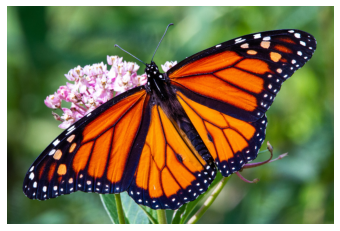

In [18]:
img_url = "https://i.imgur.com/ErgfLTn.jpg"
image, preprocessed_image = load_image_from_url(img_url)

# https://unsplash.com/photos/Ho93gVTRWW8
plt.imshow(image)
plt.axis("off")
plt.show()

In [19]:
a,b,c = pretrained_model.predict(preprocessed_image)
logits            = a
sa_atn_score_dict = b
ca_atn_score_dict = c

predicted_label = imagenet_labels[int(np.argmax(logits))]
print(predicted_label)

1/1 [==============================] - 3s 3s/step
monarch, monarch_butterfly, milkweed_butterfly, Danaus_plexippus


In [20]:
# (batch_size, nb_attention_heads, num_cls_token, seq_length)
print("class attention block에서 얻어진 attention score의 shape")
print(ca_atn_score_dict["ca_ffn_block_0_att"].shape)

class attention block에서 얻어진 attention score의 shape
(1, 4, 1, 197)


In [21]:
# Reference:
# https://github.com/facebookresearch/dino/blob/main/visualize_attention.py

patch_size = 16


def get_cls_attention_map(
    attn_score_dict=ca_atn_score_dict,
    block_key="ca_ffn_block_0_att",
    return_saliency=False,
) -> np.ndarray:
    """
    Returns attention scores from a particular attention block.

    Args:
        attn_score_dict: dict where the attention layer names are keys and corresponding
            attention scores are values.
        block_key: name of the attention block which we want to visualize.
        return_saliency: a boolean flag if set to True also returns the salient
            representations of the attention block.
    """
    w_featmap = preprocessed_image.shape[2] // patch_size
    h_featmap = preprocessed_image.shape[1] // patch_size

    attention_scores = attn_score_dict[block_key]
    nh = attention_scores.shape[1]  # Number of attention heads.

    # Taking the representations from CLS token.
    attentions = attention_scores[0, :, 0, 1:].reshape(nh, -1)

    # Reshape the attention scores to resemble mini patches.
    attentions = attentions.reshape(nh, w_featmap, h_featmap)

    if not return_saliency:
        attentions = attentions.transpose((1, 2, 0))

    else:
        attentions = np.mean(attentions, axis=0)
        attentions = (attentions - attentions.min()) / (
            attentions.max() - attentions.min()
        )
        attentions = np.expand_dims(attentions, -1)

    # Resize the attention patches to 224x224 (224: 14x16)
    attentions = tf.image.resize(
        attentions,
        size=(h_featmap * patch_size, w_featmap * patch_size),
        method="bicubic",
    )

    return attentions


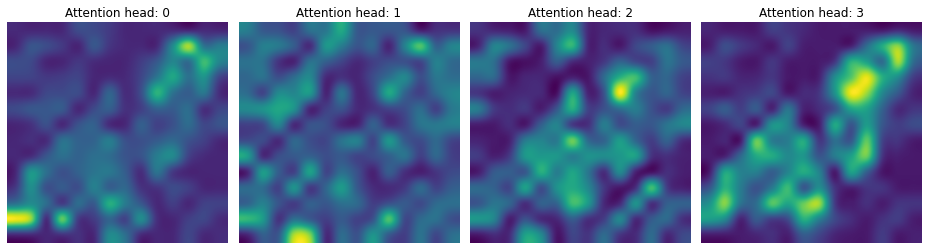

In [22]:
attentions_ca_block_0 = get_cls_attention_map()


fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(13, 13))
img_count = 0

for i in range(attentions_ca_block_0.shape[-1]):
    if img_count < attentions_ca_block_0.shape[-1]:
        axes[i].imshow(attentions_ca_block_0[:, :, img_count])
        axes[i].title.set_text(f"Attention head: {img_count}")
        axes[i].axis("off")
        img_count += 1

fig.tight_layout()
plt.show()

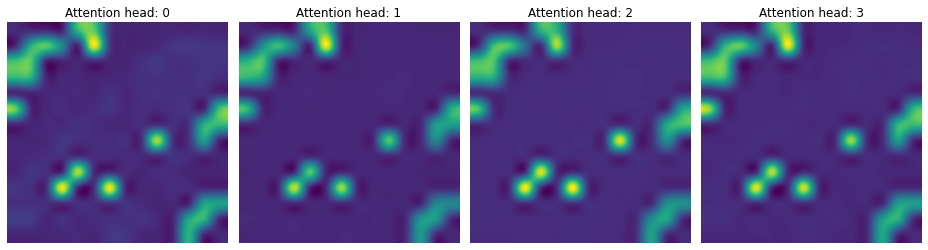

In [23]:
attentions_ca_block_1 = get_cls_attention_map(block_key="ca_ffn_block_1_att")


fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(13, 13))
img_count = 0

for i in range(attentions_ca_block_1.shape[-1]):
    if img_count < attentions_ca_block_1.shape[-1]:
        axes[i].imshow(attentions_ca_block_1[:, :, img_count])
        axes[i].title.set_text(f"Attention head: {img_count}")
        axes[i].axis("off")
        img_count += 1

fig.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


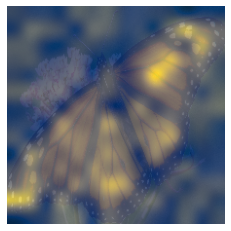

In [24]:
saliency_attention = get_cls_attention_map(return_saliency=True)

image = np.array(image)
image_resized = tf.expand_dims(image, 0)
resize_size = int((256 / 224) * image_size)
image_resized = tf.image.resize(
    image_resized, (resize_size, resize_size), method="bicubic"
)
image_resized = crop_layer(image_resized)

plt.imshow(image_resized.numpy().squeeze().astype("int32"))
plt.imshow(saliency_attention.numpy().squeeze(), cmap="cividis", alpha=0.9)
plt.axis("off")

plt.show()